# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [3]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data[data.income == '>50K'].shape[0]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data[data.income == '<=50K'].shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / float(n_records)

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent*100)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

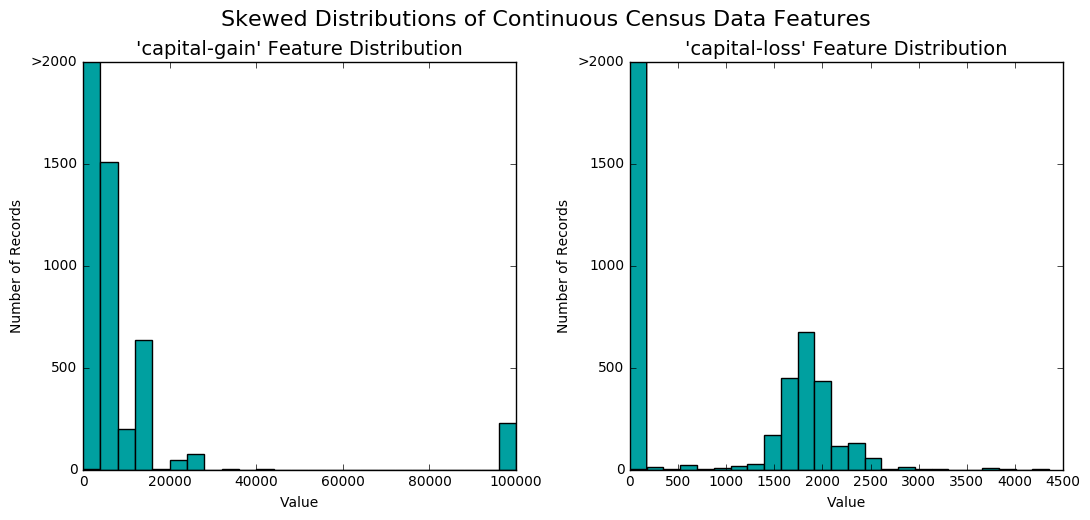

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

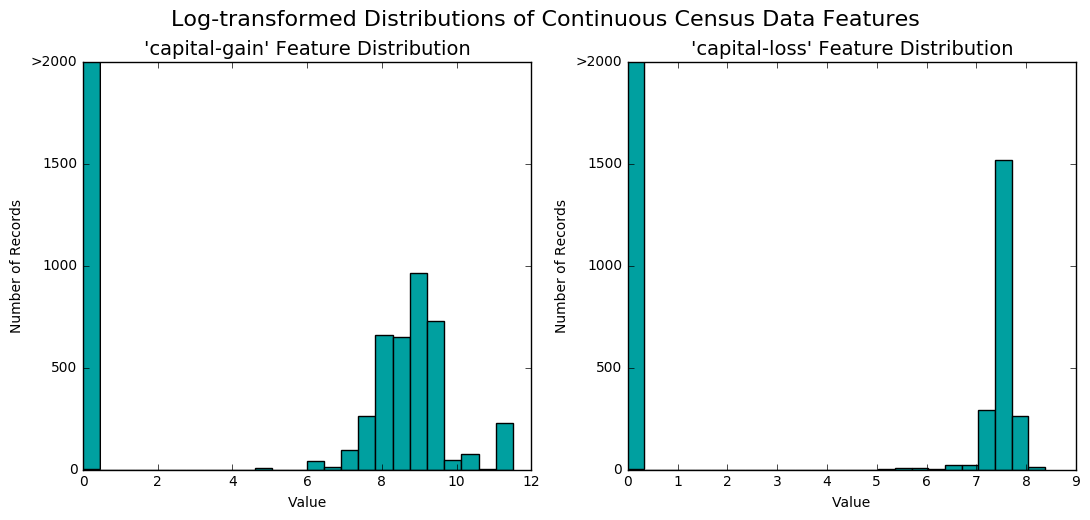

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [27]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
#income = income_raw.apply(lambda x: 0 if x == '<=50K' else 1)
income = pd.get_dummies(income_raw)['>50K']

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
# print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [28]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score as recall
from sklearn.metrics import fbeta_score

# Generate a DataFrame with predictions that every individual had income >50K
pred = pd.Series(np.repeat(1, 45222).T)

# Calculate accuracy
accuracy = accuracy_score(income, pred)

# Calculate recall
rec = recall(income, pred)

# Calculate F-score using the formula above for beta = 0.5
fscore = (1 + 0.5**2) * accuracy * rec / (0.5**2 * accuracy + rec)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: ** I have provided a short description, strengths, weaknesses, examples and applicability for the problem at hand for each of the given supervised learning models in the following table, in order to become more familiar with them.


| Model        | Description  | Strengths | Weaknesses | Examples | Applicability |
| ------------ | ------------ | --------- | ---------- | -------- | ------------- |
| Gaussian Naive Bayes |  probabilistic classifier based on applying Bayes' theorem | simple; scalable; can be very fast relative to more sophisticated methods; performs well on a wide variety of real world problems | assumption of independence between every pair of features (naive), simple representation doesn't allow for rich hypotheses | spam categorization; document classification; sentiment analysis| Bayes' theorem depends on prior knowledge of conditions, so not well suited for this type of problem |
| Decision Trees      | used for classification and regression and when there is a linear decision boundary | cost of using the tree for predictions is logarithmic in the number of data points used for training (fast); handles numerical and categorical data; easy to interpret; validation with statistical tests | prone to overfitting (overly complex trees); can be unstable (helped by ensembles); based on heuristic algorithms and cannot guarantee to return globally optimal decision tree | text classification; decision analysis | a decision tree uses a set of rules to classify data into categories by determining which features are most important, so is appropriate for this problem |
| Ensemble Methods | combine predictions of multiple base estimators (by taking a vote) to help with generalizability | more robust than any single estimator; include averaging and boosting methods; do not expect linear features or features that interact linearly; handle high dimensional spaces and large number of training examples very well | require more computation relative to other methods | wide applications including problems in finance and healthcare |  also appropriate as they can improve upon decision trees |
| K-Nearest Neighbors | non-parametric method used for classification and regression; input is k nearest training examples in feature space and the output is a classification of an object by a majority vote of its neighbours; example of an instance based learning | weights assigned so that nearer neighbors contribute more; robust to noisy training data | sensitive to local structure of the data; computation cost is high | concept search in text; recommender systems | often used to find similar items to an example; could be used for this problem but isn't the best suited approach|
| SGD | random samples from a distribution are picked and adjustments are made after each sampling in an attempt to minimize a differentiable cost function | simple yet efficient approach to discriminative learning of linear classifiers |requires a number of hyperparameters; sensitive to feature scaling | text classification; natural language processing | tries to minimize a cost function; could be applied to this problem because we don't know what the optimal feature weights are but possibly over-complicated for the problem at hand |
| SVMs | set of supervised learning methods used for classification, regression and outliers detection; primarily used for binary classification | focus only on the points that are the most difficult to tell apart (close to a boundary); can efficiently perform a non-linear classification (using the kernel trick); effective in high dimensional spaces | speed; selection of the kernel function parameters;  high algorithmic complexity; extensive memory requirements | face recognition; text classification| we could use a binary SVM here because our data is linearly separable with only two categories (0 and 1) but also overly complicated for this problem |
| Logistic Regression | regression linear model used for classification where the dependent variable is categorical; makes probabilistic predictions; used when there is a single decision boundary | robust (does not require normal distribution of independent variables); simple; has low variance and less prone to over-fitting | requires a lot of data to produce stable results; cannot be applied to continuous variables; expects features that interact linearly | imagine categorization; prediction of election results; prediction of income; healthcare  | good choice for predicting binary outcomes, so a good choice for this problem | 



I have decided to go with Logistic Regression, Decision Trees and a Random Forest. Based on everything I have read so far, they seem like a good choice with wide applications to real world problems.

************************************************************************************************

### Logistic Regression


* **Real-world application**

   Logistic regression was used in a correlational research study. The independent variables were: total score in the    Scientific Thinking Skills Scale, total score in the Epistemological Belief Scale and total score in the Fatalism      Scale. The dependent (predicted) variable was the level of critical thinking (defined categorically, e.g. low and high). The study consisted of 200 students from Ankara University, Faculty of Educational Sciences, Department of Guidance and Psychological Counseling during the 2006-2007 academic years. The students were divided into two groups according to their scores as high and low critical thinking level groups. The scores for this classification were almost the normal distributed arithmetic mean was used as cut-off point. The mean of the group according to their scores from the scale was approximately 220 and the students with the same or a lower score were assigned to “low”, those with a higher score were assigned to “high” critical thinking level category. Thus, the dichotomous dependent variable for the analysis was obtained.


* **Strengths**

   It is robust (does not require normal distribution of independent variables), simple, has low variance and less prone to overfitting.
   

* **Weaknesses**

   It assumes that there is one smooth linear decision boundary and will perform poorly if that is not the case. Requires a lot of data to produce reliable results and cannot be applied for continuous variables.
   

* **Applicability**

   It is suitable for binary classification problems. The dataset is linearly separable and LR performs well even with many more features than we have in this problem (even after one-hot encoding). It is well positioned to perform well right out of the box without excessively fine-tuning the parameters.

#### References
* Logistic Regression: Concept and Application - http://files.eric.ed.gov/fulltext/EJ919857.pdf

************************************************************************************************

### Decision Tree


* **Real-world application**

  Many examples of real world applications for decision trees are outlined in the article "Decision Tree Applications for Data Modelling (Artificial Intelligence)"; including business management, customer relationship management, fraudulent statement detection and energy consumption. For example, for fraudulent statement detection, the decision tree approach has proven useful as it can take into account all variables during the model development process. In a Greek study, 76 manufacturing firms were selected and their financial statements (balance sheets, income statements) were collected. The decision tree model that was constructed from the data managed to classify all non-fraud cases, and 92% of the fraud cases correctly. 


* **Strengths**

   They are fast because the cost of using a tree for predictions is logarithmic in the number of data points used for training. In our case, this is np.log(36177), which is ~10.5. This means we can reach a leaf node (decision) by asking ~11 questions which separate the data approximately 50/50. They can handle numerical and categorical data (do not require one-hot encoding) and the results are easy to interpret and validate. They also require very little input and data preparation.
   

* **Weaknesses**

   They are prone to creating overly complex trees that do not generalize the data very well and are sensitive to small pertrubations in the data. They assume the decision boundaries are parallel to the axes. Globally optimal decision tree cannot be guaranteed.
   

* **Applicability**

   It is easy and fast. It can be used for this dataset to find out which features are correlated with the target variable. The dataset does not include pertrubations which can cause the model to behave unpredictably. The feature set is not large enough (even after one-hot encoding) to cause overly complex tree structures to emerge.

#### References
* Decision Tree Applications for Data Modelling (Artificial Intelligence) - http://what-when-how.com/artificial-intelligence/decision-tree-applications-for-data-modelling-artificial-intelligence/



************************************************************************************************

### Random Forest


* **Real-world application**

   Random forests are widely used in the real world. One example is the analysis of mass spectrometry-based proteomics data as described in the paper "Random Forest for Bioinformatics" (page 8). Random forest holds a unique position in analyzing mass spectrometry-based proteomics data for clinical classifications, since it considers feature interactions in learning and is well suited for high-dimensional data samples. For instance, RF has been demonstrated by Izmirlian et al. in classifying SELDI-TOF (surface-enhanced laser desorption/ionization time of flight) proteomic data well with the advantages of robustness to noise and less dependence on tuning parameters. Later, Geurts et al. presented a related tree ensemble approach named “extra-trees” which selects at each node the best among K randomly generated splits. Unlike random forest which is grown with multiple sample subsets, the base trees of extra-trees are grown from the complete training set and by explicitly randomizing the splits. The approach was successfully validated on two SELDI-TOF datasets for the diagnosis of rheumatoid arthritis and inflammatory bowel diseases.


* **Strengths**

   A random forest usually performs better than any single decision tree classifier, as it can generalize better by aggregating the results of all the classifiers in the forest. It is fast, parallelizable and easy to validate.
   

* **Weaknesses**

   It is more computationally intensive compared to other methods. For data including categorical variables with different number of levels, random forests are biased in favour of those attributes with more levels. So, the feature importance scores are not reliable for these types of data.
   

* **Applicability**

   This method is appropriate for this problem for the same reasons a decision tree is but additionally it is more likely to avoid overfitting as the estimators' results are averaged out. 

#### References
* Random Forest for Bioinformatics  - https://www.cs.cmu.edu/~qyj/papersA08/11-rfbook.pdf

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [16]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    # slice the data and get the sample_size first data points
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start # in seconds
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


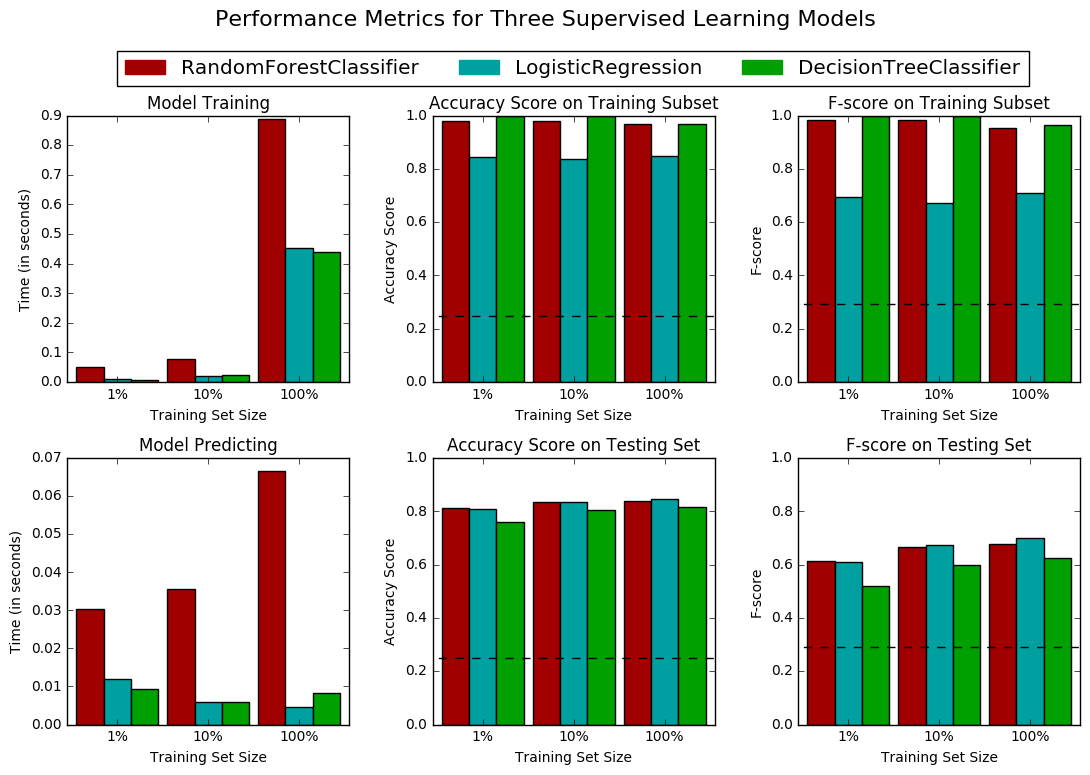

In [17]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# TODO: Initialize the three models
clf_A = LogisticRegression(random_state=11)
clf_B = DecisionTreeClassifier(random_state=11)
clf_C = RandomForestClassifier(random_state=11)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(X_train.shape[0] * 0.01)
samples_10 = int(X_train.shape[0] * 0.1)
samples_100 = X_train.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [18]:
for i in results.items():
    print i[0]
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

RandomForestClassifier


,1%,10%,100%
acc_test,0.813156,0.833831,0.840575
acc_train,0.980000,0.980000,0.966667
f_test,0.614324,0.666741,0.678445
f_train,0.982143,0.982143,0.952381
pred_time,0.030480,0.035655,0.066483
train_time,0.050576,0.076022,0.889645


LogisticRegression


,1%,10%,100%
acc_test,0.810835,0.836926,0.848314
acc_train,0.843333,0.836667,0.850000
f_test,0.608164,0.674581,0.699293
f_train,0.694444,0.671642,0.708955
pred_time,0.011888,0.005950,0.004681
train_time,0.011197,0.020636,0.451720


DecisionTreeClassifier


,1%,10%,100%
acc_test,0.758872,0.804865,0.817579
acc_train,1.000000,0.996667,0.970000
f_test,0.518053,0.600196,0.625865
f_train,1.000000,0.997191,0.963855
pred_time,0.009241,0.005921,0.008338
train_time,0.008001,0.024588,0.439325


----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: ** Based on the evaluation, it looks like the Logistic Regression classifier is best suited for this problem. It consistently took the least amount of time for model prediction, its accuracy  and F-score on the entire testing set are the highest. LR is suitable for binary classification problems like this one and the dataset is linearly separable, so this approach is suitable for the data.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** Logistic Regression uses an existing dataset (in this case census data) and analyses the given features (e.g. age, workclass, occupation, etc) that are provided for each individual, in order to be able to make predictions about new data. With the census data, the information that the model is trying to predict is whether an individual earns more than 50K. The model learns from the data and finds patterns in it, so that it can assign weights to each feature (based on its importance in determining the correct answer, e.g. is age important in determining someone's income?). When the model is used to predict the income for a new individual, the features that belong to the individual are combined with the weights that the model has found work best. Then, the summed up value is passed through a function called sigmoid (S shaped curve) which, then, outputs the probability that this data point belongs to the category that we are interested in (in our case "earning more than 50K" or "not earning more than 50K").



### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [19]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = LogisticRegression(random_state=11)

# TODO: Create the parameters list you wish to tune
parameters = {
    'penalty': ['l1', 'l2'],
    'C': np.arange(0.8, 1.2, 0.1)
}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8483
F-score on testing data: 0.6993

Optimized Model
------
Final accuracy score on the testing data: 0.8493
Final F-score on the testing data: 0.7009


In [21]:
# Print best params after the grid search
grid_fit.best_params_

{'C': 0.80000000000000004, 'penalty': 'l1'}

### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |     0.2478          |      0.8483       |     0.8493      |
| F-score        |     0.2917          |      0.6993       |     0.7009      |


**Answer: ** The optimized model's accuracy on the testing data is 0.8493 and its F-score is 0.7009. The scores of the otimised model are only slightly better (accuracy is better by 0.001, or 0.1%) than the scores for the unoptimised model, but are significantly higher than the naive benchmark predictor (accuracy has improved by 60%).

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:** I believe that the features most important for prediction are (ranked, 1 - highest):
1. education_level or education-num
2. capital-gain
3. age
4. occupation
5. marital-status

I have ranked them in such a way because I believe education is most strongly correlated with income, as it, in most cases, it determines the type of career someone can have. Some professions are limited only to people that have obtained certain qualifications. Next, I think capital gain has a lot to say about someone's behaviour and their understanding of economics. Age is usually a good indicator because people tend to climb the salary ladder with age. Occupation is also a good indicator because different occupations have salary bands that are typical for them. I think marital status also has an influence because unmarried people can more freely pursue their ambitions.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

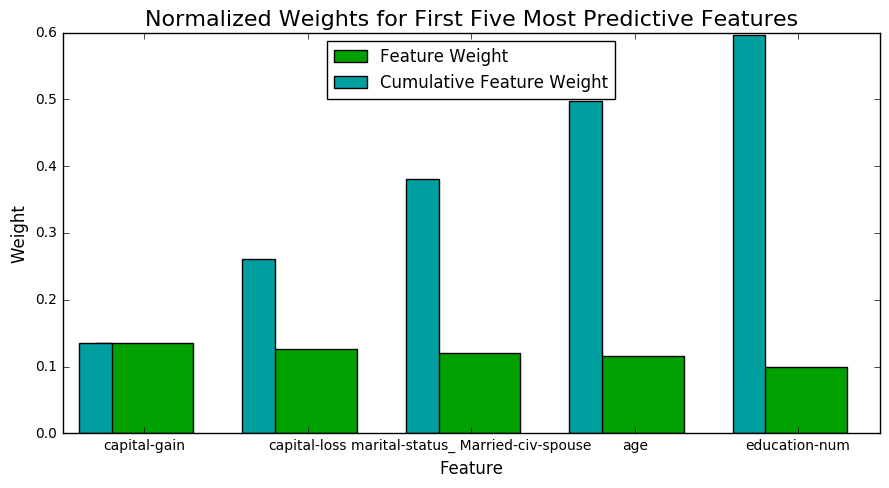

In [23]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import GradientBoostingClassifier

# TODO: Train the supervised model on the training set 
model = GradientBoostingClassifier(random_state=11, n_estimators=100)
model.fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_[::-1]

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:** The most important features according to the Gradient Boosting classifier are (ranked by importance):
1. capital-gain
2. capital-loss
3. marital-status_Married-civ-spouse
4. age
5. education-num

I did not got any features ranked correctly, but I included 3 out of the 5 most important features. I overestimated the importance of education-num, age and occupation; and I underestimated the importance of capital-gain, capital-loss and marital-status_Married-civ-spouse. I'd guess age is less important because it's less indicative of income and more weakly correlated with it than I had anticipated. I was surprised to find out that marital-status is so influential. My guess is that once people get married or start a family, they are under more pressure to find a stable and well paying job. I think capital-gain and capital-loss are both important because they provide an overview of someone's prior financial decisions.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [69]:
# Import functionality for cloning a model
from sklearn.base import clone

start = time() # Get start time

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

end = time() # Get end time

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))
print "\nTime spent training and predicting {:.4f}".format(end - start)

Final Model trained on full data
------
Accuracy on testing data: 0.8493
F-score on testing data: 0.7009

Final Model trained on reduced data
------
Accuracy on testing data: 0.8353
F-score on testing data: 0.6683

Time spent training and predicting 0.2290


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:** The final model's F-score and accuracy score have suffered minor penalties after limiting the number of features. The model's F-score is lower by 0.0326 (~3.3%), and its accuracy score is lower by 0.0140 (~1.4%). 

From the performance metrics earlier, I can gather that the Logistic Regression classifier spent ~0.46 seconds on  training and predicting on the entire dataset. The classifier spent 0.2290 seconds on training and predicting on the reduced data set. If training time is a factor, I would not consider using the reduced data as a training set because the time savings are negligible and I'd prioritise accuracy in this case.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.